# Predictive Modeling: IMDB Movie Rating Analysis

**Author:** Data Mining Project  
**Dataset:** IMDB Movies Processed Dataset  
**Objective:** Build end-to-end predictive models for movie rating prediction (regression) and hit classification

---

## Project Overview

This notebook implements comprehensive machine learning models to:
1. **Regression:** Predict `averageRating` using movie features
2. **Classification:** Predict whether a movie is a "hit" (rating ≥ 7.0)

**Key Sections:**
- Data loading & preprocessing
- Feature engineering
- Multiple regression models (Linear, RF, XGBoost)
- Classification models (Logistic, RF)
- Cross-validation & hyperparameter tuning
- Feature importance analysis
- Genre-stratified modeling
- Residual analysis & model comparison

## 1. Setup & Library Imports

Import all required libraries for data manipulation, modeling, and visualization.

In [1]:
# Data manipulation
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn preprocessing
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

# Regression models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Classification models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Metrics
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
)

# Utilities
from time import time

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("✓ All libraries imported successfully!")

/Users/vaishnavverma/.matplotlib is not a writable directory
Matplotlib created a temporary cache directory at /var/folders/gp/0qsbr0x11d315dt15fl17c940000gn/T/matplotlib-k8mo2uf1 because there was an issue with the default path (/Users/vaishnavverma/.matplotlib); it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib is building the font cache; this may take a moment.


✓ All libraries imported successfully!


## 2. Data Loading

Load the processed IMDB dataset and perform initial exploration.

In [2]:
# Load dataset
df = pd.read_csv('../data/processed/imdb_movies_processed.csv')

print(f"Dataset Shape: {df.shape}")
print(f"Rows: {df.shape[0]:,} | Columns: {df.shape[1]}")
print("\n" + "="*60)

# Display first few rows
print("\nFirst 5 rows:")
df.head()

Dataset Shape: (337971, 32)
Rows: 337,971 | Columns: 32


First 5 rows:


,tconst,primaryTitle,originalTitle,titleType,isAdult,startYear,runtimeMinutes,genres,averageRating,numVotes,decade,primaryGenre,numGenres,logVotes,bayes_rating,runtime_bin,genre_Action,genre_Adult,genre_Adventure,genre_Animation,genre_Biography,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Family,genre_Fantasy,genre_Horror,genre_Other,genre_Romance,genre_Thriller,genre_Unknown
0,tt0000009,Miss Jerry,Miss Jerry,movie,0,1894.0,45.0,Romance,5.2,232.0,1890,Romance,1,5.451038,5.735783,Short (<60),False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
1,tt0000147,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,movie,0,1897.0,100.0,"Documentary,News,Sport",5.3,577.0,1890,Documentary,3,6.359574,5.594038,Standard (90-120),False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
2,tt0000335,Soldiers of the Cross,Soldiers of the Cross,movie,0,1900.0,40.0,"Biography,Drama",5.5,64.0,1900,Biography,2,4.174387,6.020188,Short (<60),False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
3,tt0000502,Bohemios,Bohemios,movie,0,1905.0,100.0,Unknown,3.3,26.0,1900,Unknown,0,3.295837,5.912001,Standard (90-120),False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
4,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,movie,0,1906.0,70.0,"Action,Adventure,Biography",6.0,1037.0,1900,Action,3,6.945051,6.029294,Medium (60-90),True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [3]:
# Dataset information
print("Column Data Types:")
print(df.dtypes)
print("\n" + "="*60)

print("\nMissing Values Summary:")
missing = df.isnull().sum()
missing_pct = 100 * missing / len(df)
missing_df = pd.DataFrame({
    'Missing_Count': missing,
    'Percentage': missing_pct
}).sort_values('Missing_Count', ascending=False)
print(missing_df[missing_df['Missing_Count'] > 0])

Column Data Types:
tconst                object
primaryTitle          object
originalTitle         object
titleType             object
isAdult                int64
startYear            float64
runtimeMinutes       float64
genres                object
averageRating        float64
numVotes             float64
decade                 int64
primaryGenre          object
numGenres              int64
logVotes             float64
bayes_rating         float64
runtime_bin           object
genre_Action            bool
genre_Adult             bool
genre_Adventure         bool
genre_Animation         bool
genre_Biography         bool
genre_Comedy            bool
genre_Crime             bool
genre_Documentary       bool
genre_Drama             bool
genre_Family            bool
genre_Fantasy           bool
genre_Horror            bool
genre_Other             bool
genre_Romance           bool
genre_Thriller          bool
genre_Unknown           bool
dtype: object


Missing Values Summary:
Empty DataFra

In [4]:
# Statistical summary
print("Statistical Summary of Key Numeric Columns:")
df[['averageRating', 'numVotes', 'runtimeMinutes']].describe()

Statistical Summary of Key Numeric Columns:


,averageRating,numVotes,runtimeMinutes
count,337971.000000,337971.000000,337971.000000
mean,6.124226,2464.437131,94.235325
std,1.375391,14409.801159,167.636475
min,1.000000,5.000000,1.000000
25%,5.300000,20.000000,82.000000
50%,6.200000,63.000000,91.000000
75%,7.000000,320.000000,101.000000
max,10.000000,158437.850000,59460.000000


## 3. Data Cleaning & Feature Engineering

Prepare the dataset for modeling:
- Drop non-predictive identifiers
- Encode categorical variables
- Create classification target (hit label)
- Handle missing values
- Engineer features

In [39]:
# Create a copy for processing
df_model = df.copy()[:10000]  # Limit to first 10,000 rows for efficiency   

# Check available columns
print("Available columns:")
print(df_model.columns.tolist())
print("\n" + "="*60)

Available columns:
['tconst', 'primaryTitle', 'originalTitle', 'titleType', 'isAdult', 'startYear', 'runtimeMinutes', 'genres', 'averageRating', 'numVotes', 'decade', 'primaryGenre', 'numGenres', 'logVotes', 'bayes_rating', 'runtime_bin', 'genre_Action', 'genre_Adult', 'genre_Adventure', 'genre_Animation', 'genre_Biography', 'genre_Comedy', 'genre_Crime', 'genre_Documentary', 'genre_Drama', 'genre_Family', 'genre_Fantasy', 'genre_Horror', 'genre_Other', 'genre_Romance', 'genre_Thriller', 'genre_Unknown']



In [40]:
# Step 1: Drop non-predictive identifiers
columns_to_drop = ['tconst']

# Check if 'titles' column exists (might be named differently)
if 'titles' in df_model.columns:
    columns_to_drop.append('titles')
elif 'primaryTitle' in df_model.columns:
    columns_to_drop.append('primaryTitle')
elif 'title' in df_model.columns:
    columns_to_drop.append('title')

print(f"Dropping columns: {columns_to_drop}")
df_model = df_model.drop(columns=[col for col in columns_to_drop if col in df_model.columns], errors='ignore')

print(f"Dataset shape after dropping identifiers: {df_model.shape}")

Dropping columns: ['tconst', 'primaryTitle']
Dataset shape after dropping identifiers: (10000, 30)


In [41]:
# Step 2: Create classification target - 'hit' label
# hit = 1 if averageRating >= 7.0, else 0
df_model['hit'] = (df_model['averageRating'] >= 7.0).astype(int)

print("Classification target distribution:")
print(df_model['hit'].value_counts())
print(f"\nHit rate: {100 * df_model['hit'].mean():.2f}%")

Classification target distribution:
hit
0    8653
1    1347
Name: count, dtype: int64

Hit rate: 13.47%


In [42]:
# Step 3: Handle missing values in key numeric columns
# Impute runtimeMinutes with median
if 'runtimeMinutes' in df_model.columns:
    if df_model['runtimeMinutes'].isnull().sum() > 0:
        median_runtime = df_model['runtimeMinutes'].median()
        df_model['runtimeMinutes'].fillna(median_runtime, inplace=True)
        print(f"✓ Imputed runtimeMinutes with median: {median_runtime}")

# Ensure logVotes exists and is numeric
if 'logVotes' in df_model.columns:
    df_model['logVotes'] = pd.to_numeric(df_model['logVotes'], errors='coerce')
    if df_model['logVotes'].isnull().sum() > 0:
        df_model['logVotes'].fillna(df_model['logVotes'].median(), inplace=True)
        print(f"✓ Imputed logVotes")
elif 'numVotes' in df_model.columns:
    # Create logVotes if it doesn't exist
    df_model['logVotes'] = np.log1p(df_model['numVotes'])
    print("✓ Created logVotes from numVotes")

print("\nMissing values after imputation:")
print(df_model.isnull().sum()[df_model.isnull().sum() > 0])


Missing values after imputation:
Series([], dtype: int64)


In [43]:
# Step 4: Encode categorical variables

# Encode director using LabelEncoder
if 'director' in df_model.columns:
    le_director = LabelEncoder()
    # Handle missing directors
    df_model['director'].fillna('Unknown', inplace=True)
    df_model['director_encoded'] = le_director.fit_transform(df_model['director'].astype(str))
    print(f"✓ Encoded director: {df_model['director_encoded'].nunique()} unique directors")
    # Keep original for later analysis
else:
    print("⚠ director column not found")

# Ensure decade is numeric
if 'decade' in df_model.columns:
    df_model['decade'] = pd.to_numeric(df_model['decade'], errors='coerce')
    df_model['decade'].fillna(df_model['decade'].median(), inplace=True)
    print(f"✓ Decade is numeric")

# Handle primaryGenre - one-hot encode if needed
if 'primaryGenre' in df_model.columns:
    # Check if genre_* columns already exist
    genre_cols = [col for col in df_model.columns if col.startswith('genre_')]
    if len(genre_cols) == 0:
        # Create one-hot encoding
        genre_dummies = pd.get_dummies(df_model['primaryGenre'], prefix='genre')
        df_model = pd.concat([df_model, genre_dummies], axis=1)
        print(f"✓ Created {len(genre_dummies.columns)} genre one-hot columns")
    else:
        print(f"✓ Using existing {len(genre_cols)} genre columns")

# Handle runtime_bin - one-hot encode if needed
if 'runtime_bin' in df_model.columns:
    runtime_bin_cols = [col for col in df_model.columns if col.startswith('runtime_bin_')]
    if len(runtime_bin_cols) == 0:
        runtime_dummies = pd.get_dummies(df_model['runtime_bin'], prefix='runtime_bin')
        df_model = pd.concat([df_model, runtime_dummies], axis=1)
        print(f"✓ Created {len(runtime_dummies.columns)} runtime_bin one-hot columns")
    else:
        print(f"✓ Using existing {len(runtime_bin_cols)} runtime_bin columns")

print(f"\nFinal dataset shape: {df_model.shape}")

⚠ director column not found
✓ Decade is numeric
✓ Using existing 16 genre columns
✓ Created 5 runtime_bin one-hot columns

Final dataset shape: (10000, 36)


In [44]:
# Step 5: Prepare feature matrix X and target variables

# Define target variables
y_reg = df_model['averageRating'].copy()
y_cls = df_model['hit'].copy()

# Select feature columns (exclude targets and original categorical columns)
exclude_cols = ['averageRating', 'hit', 'director', 'primaryGenre', 'runtime_bin']

# Get all feature columns
feature_cols = [col for col in df_model.columns if col not in exclude_cols]

# Remove any remaining non-numeric columns
X = df_model[feature_cols].copy()

# Convert all to numeric
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')

# Drop columns with all NaN
X = X.dropna(axis=1, how='all')

# Replace infinities with NaN, then fill with median
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())

# Ensure all values are float64
X = X.astype('float64')
clean_X = X.copy()
clean_X.columns = (
    clean_X.columns
    .str.replace('[', '_', regex=False)
    .str.replace(']', '_', regex=False)
    .str.replace('<', '_', regex=False)
    .str.replace('>', '_', regex=False)
    .str.replace(',', '_', regex=False)
    .str.replace(' ', '_', regex=False)
)

X = clean_X
print(f"✓ Feature matrix prepared successfully")
print(f"\nFeature matrix shape: {X.shape}")
print(f"Regression target shape: {y_reg.shape}")
print(f"Classification target shape: {y_cls.shape}")
print(f"\nNumber of features: {X.shape[1]}")
print(f"\nFeature columns:")
print(X.columns.tolist())

✓ Feature matrix prepared successfully

Feature matrix shape: (10000, 30)
Regression target shape: (10000,)
Classification target shape: (10000,)

Number of features: 30

Feature columns:
['originalTitle', 'isAdult', 'startYear', 'runtimeMinutes', 'numVotes', 'decade', 'numGenres', 'logVotes', 'bayes_rating', 'genre_Action', 'genre_Adult', 'genre_Adventure', 'genre_Animation', 'genre_Biography', 'genre_Comedy', 'genre_Crime', 'genre_Documentary', 'genre_Drama', 'genre_Family', 'genre_Fantasy', 'genre_Horror', 'genre_Other', 'genre_Romance', 'genre_Thriller', 'genre_Unknown', 'runtime_bin_Long_(120-150)', 'runtime_bin_Medium_(60-90)', 'runtime_bin_Short_(_60)', 'runtime_bin_Standard_(90-120)', 'runtime_bin_Very_Long_(_150)']


## 4. Train/Test Split

Split data into training (80%) and testing (20%) sets with stratification for classification target.

In [45]:
# Perform stratified train-test split (80/20)
X_train, X_test, y_reg_train, y_reg_test, y_cls_train, y_cls_test = train_test_split(
    X, y_reg, y_cls, 
    test_size=0.2, 
    random_state=42,
    stratify=y_cls  # Stratify based on classification target
)

print("Train/Test Split Results:")
print("=" * 60)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape:  {X_test.shape}")
print(f"\nRegression targets:")
print(f"  y_reg_train: {y_reg_train.shape}")
print(f"  y_reg_test:  {y_reg_test.shape}")
print(f"\nClassification targets:")
print(f"  y_cls_train: {y_cls_train.shape}")
print(f"  y_cls_test:  {y_cls_test.shape}")

print(f"\nTraining set hit rate: {100 * y_cls_train.mean():.2f}%")
print(f"Test set hit rate:     {100 * y_cls_test.mean():.2f}%")

Train/Test Split Results:
X_train shape: (8000, 30)
X_test shape:  (2000, 30)

Regression targets:
  y_reg_train: (8000,)
  y_reg_test:  (2000,)

Classification targets:
  y_cls_train: (8000,)
  y_cls_test:  (2000,)

Training set hit rate: 13.48%
Test set hit rate:     13.45%


In [46]:
# Standardize features for linear models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for consistency
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("✓ Features standardized for linear/logistic models")

✓ Features standardized for linear/logistic models


## 5. Regression Models: Predict Average Rating

Build and evaluate three regression models to predict `averageRating`:
1. **Linear Regression** - Baseline linear model
2. **Random Forest Regressor** - Ensemble tree-based model
3. **XGBoost Regressor** - Gradient boosting model

**Evaluation Metrics:**
- **R² Score:** Proportion of variance explained (higher is better)
- **RMSE:** Root Mean Squared Error (lower is better)
- **MAE:** Mean Absolute Error (lower is better)

In [47]:
# Initialize regression models
reg_models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1, verbosity=0)
}

# Store results
reg_results = []

print("Training Regression Models...")
print("=" * 80)

for model_name, model in reg_models.items():
    print(f"\n🔹 {model_name}")
    
    # Choose scaled or unscaled features
    if 'Linear' in model_name:
        X_tr, X_te = X_train_scaled, X_test_scaled
    else:
        X_tr, X_te = X_train, X_test
    
    # Train
    start_time = time()
    model.fit(X_tr, y_reg_train)
    train_time = time() - start_time
    
    # Predict
    y_pred = model.predict(X_te)
    
    # Evaluate
    r2 = r2_score(y_reg_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_reg_test, y_pred))
    mae = mean_absolute_error(y_reg_test, y_pred)
    
    # Store results
    reg_results.append({
        'Model': model_name,
        'R²': r2,
        'RMSE': rmse,
        'MAE': mae,
        'Training Time (s)': train_time
    })
    
    print(f"  R² Score: {r2:.4f}")
    print(f"  RMSE:     {rmse:.4f}")
    print(f"  MAE:      {mae:.4f}")
    print(f"  Time:     {train_time:.2f}s")

print("\n" + "=" * 80)

Training Regression Models...



🔹 Linear Regression
  R² Score: 0.4470
  RMSE:     0.7347
  MAE:      0.5098
  Time:     0.11s

🔹 Random Forest
  R² Score: 0.9974
  RMSE:     0.0504
  MAE:      0.0151
  Time:     0.45s

🔹 XGBoost
  R² Score: 0.9978
  RMSE:     0.0465
  MAE:      0.0245
  Time:     0.17s



In [48]:
# Display regression results comparison table
reg_results_df = pd.DataFrame(reg_results)
print("\n📊 Regression Models Comparison:")
print(reg_results_df.to_string(index=False))


📊 Regression Models Comparison:
            Model       R²     RMSE      MAE  Training Time (s)
Linear Regression 0.446983 0.734739 0.509779           0.110204
    Random Forest 0.997397 0.050405 0.015051           0.445866
          XGBoost 0.997784 0.046513 0.024480           0.168926


### Interpretation

- **Linear Regression** provides a baseline with simple linear relationships
- **Random Forest** captures non-linear patterns through ensemble decision trees
- **XGBoost** uses gradient boosting for optimized predictions

The best model is determined by highest R² and lowest RMSE/MAE.

## 6. Cross-Validation: Regression

Perform 5-fold cross-validation to assess model stability and generalization.

In [49]:
# 5-Fold Cross-Validation for Regression
cv_reg_results = []

print("Running 5-Fold Cross-Validation for Regression Models...")
print("=" * 80)

for model_name, model in reg_models.items():
    print(f"\n🔹 {model_name}")
    
    # Choose scaled or unscaled features
    if 'Linear' in model_name:
        X_cv = X_train_scaled
    else:
        X_cv = X_train
    
    # Perform cross-validation
    cv_scores = cross_validate(
        model, X_cv, y_reg_train,
        cv=5,
        scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'],
        n_jobs=-1
    )
    
    # Calculate metrics
    r2_mean = cv_scores['test_r2'].mean()
    r2_std = cv_scores['test_r2'].std()
    
    rmse_scores = np.sqrt(-cv_scores['test_neg_mean_squared_error'])
    rmse_mean = rmse_scores.mean()
    rmse_std = rmse_scores.std()
    
    mae_mean = -cv_scores['test_neg_mean_absolute_error'].mean()
    mae_std = cv_scores['test_neg_mean_absolute_error'].std()
    
    # Store results
    cv_reg_results.append({
        'Model': model_name,
        'R² (mean ± std)': f"{r2_mean:.4f} ± {r2_std:.4f}",
        'RMSE (mean ± std)': f"{rmse_mean:.4f} ± {rmse_std:.4f}",
        'MAE (mean ± std)': f"{mae_mean:.4f} ± {mae_std:.4f}"
    })
    
    print(f"  R² (CV):   {r2_mean:.4f} ± {r2_std:.4f}")
    print(f"  RMSE (CV): {rmse_mean:.4f} ± {rmse_std:.4f}")
    print(f"  MAE (CV):  {mae_mean:.4f} ± {mae_std:.4f}")

print("\n" + "=" * 80)

Running 5-Fold Cross-Validation for Regression Models...

🔹 Linear Regression
  R² (CV):   0.4418 ± 0.0150
  RMSE (CV): 0.7575 ± 0.0172
  MAE (CV):  0.5293 ± 0.0118

🔹 Random Forest
  R² (CV):   0.9969 ± 0.0009
  RMSE (CV): 0.0564 ± 0.0092
  MAE (CV):  0.0181 ± 0.0019

🔹 XGBoost
  R² (CV):   0.9959 ± 0.0014
  RMSE (CV): 0.0645 ± 0.0121
  MAE (CV):  0.0291 ± 0.0021



In [50]:
# Display CV results table
cv_reg_df = pd.DataFrame(cv_reg_results)
print("\n📊 Cross-Validation Results (Regression):")
print(cv_reg_df.to_string(index=False))


📊 Cross-Validation Results (Regression):
            Model R² (mean ± std) RMSE (mean ± std) MAE (mean ± std)
Linear Regression 0.4418 ± 0.0150   0.7575 ± 0.0172  0.5293 ± 0.0118
    Random Forest 0.9969 ± 0.0009   0.0564 ± 0.0092  0.0181 ± 0.0019
          XGBoost 0.9959 ± 0.0014   0.0645 ± 0.0121  0.0291 ± 0.0021


## 7. Hyperparameter Tuning: Regression

Use GridSearchCV to find optimal hyperparameters for Random Forest Regressor.

In [51]:
# Define parameter grid
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

print("Hyperparameter Tuning: Random Forest Regressor")
print("=" * 80)
print(f"Parameter grid: {param_grid_rf}")
print("\nRunning GridSearchCV (this may take a few minutes)...")

# Initialize GridSearchCV
grid_search_rf = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid_rf,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

# Fit
start_time = time()
grid_search_rf.fit(X_train, y_reg_train)
tuning_time = time() - start_time

print(f"\n✓ GridSearchCV completed in {tuning_time:.2f}s")
print("\n" + "=" * 80)
print("Best Parameters:")
print(grid_search_rf.best_params_)
print(f"\nBest R² Score (CV): {grid_search_rf.best_score_:.4f}")

Hyperparameter Tuning: Random Forest Regressor
Parameter grid: {'n_estimators': [100, 200], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5]}

Running GridSearchCV (this may take a few minutes)...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

✓ GridSearchCV completed in 24.38s

Best Parameters:
{'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}

Best R² Score (CV): 0.9969


In [52]:
# Evaluate tuned model on test set
best_rf_reg = grid_search_rf.best_estimator_
y_pred_tuned = best_rf_reg.predict(X_test)

# Calculate metrics
r2_tuned = r2_score(y_reg_test, y_pred_tuned)
rmse_tuned = np.sqrt(mean_squared_error(y_reg_test, y_pred_tuned))
mae_tuned = mean_absolute_error(y_reg_test, y_pred_tuned)

print("\n📊 Tuned Random Forest Performance on Test Set:")
print(f"  R² Score: {r2_tuned:.4f}")
print(f"  RMSE:     {rmse_tuned:.4f}")
print(f"  MAE:      {mae_tuned:.4f}")


📊 Tuned Random Forest Performance on Test Set:
  R² Score: 0.9975
  RMSE:     0.0496
  MAE:      0.0147


## 8. Classification Models: Predict "Hit" Label

Build classification models to predict whether a movie is a hit (rating ≥ 7.0):
1. **Logistic Regression** - Linear classification baseline
2. **Random Forest Classifier** - Ensemble tree-based classifier

**Evaluation Metrics:**
- Accuracy, Precision, Recall, F1-Score
- ROC-AUC Score
- Confusion Matrix
- ROC Curves

In [53]:
# Initialize classification models
cls_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
}

# Store results
cls_results = []
cls_predictions = {}

print("Training Classification Models...")
print("=" * 80)

for model_name, model in cls_models.items():
    print(f"\n🔹 {model_name}")
    
    # Choose scaled or unscaled features
    if 'Logistic' in model_name:
        X_tr, X_te = X_train_scaled, X_test_scaled
    else:
        X_tr, X_te = X_train, X_test
    
    # Train
    start_time = time()
    model.fit(X_tr, y_cls_train)
    train_time = time() - start_time
    
    # Predict
    y_pred = model.predict(X_te)
    y_pred_proba = model.predict_proba(X_te)[:, 1]
    
    # Store predictions for plotting
    cls_predictions[model_name] = {'y_pred': y_pred, 'y_pred_proba': y_pred_proba}
    
    # Evaluate
    accuracy = accuracy_score(y_cls_test, y_pred)
    precision = precision_score(y_cls_test, y_pred)
    recall = recall_score(y_cls_test, y_pred)
    f1 = f1_score(y_cls_test, y_pred)
    roc_auc = roc_auc_score(y_cls_test, y_pred_proba)
    
    # Store results
    cls_results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc,
        'Training Time (s)': train_time
    })
    
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"  ROC-AUC:   {roc_auc:.4f}")
    print(f"  Time:      {train_time:.2f}s")

print("\n" + "=" * 80)

Training Classification Models...

🔹 Logistic Regression
  Accuracy:  0.9330
  Precision: 0.8027
  Recall:    0.6654
  F1-Score:  0.7276
  ROC-AUC:   0.9749
  Time:      1.14s

🔹 Random Forest
  Accuracy:  0.9710
  Precision: 0.9731
  Recall:    0.8067
  F1-Score:  0.8821
  ROC-AUC:   0.9954
  Time:      0.13s



In [54]:
# Display classification results comparison table
cls_results_df = pd.DataFrame(cls_results)
print("\n📊 Classification Models Comparison:")
print(cls_results_df.to_string(index=False))


📊 Classification Models Comparison:
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC  Training Time (s)
Logistic Regression     0.933   0.802691 0.665428  0.727642 0.974918           1.140561
      Random Forest     0.971   0.973094 0.806691  0.882114 0.995405           0.127014


### ROC Curves

ROC (Receiver Operating Characteristic) curves visualize the trade-off between true positive rate and false positive rate.

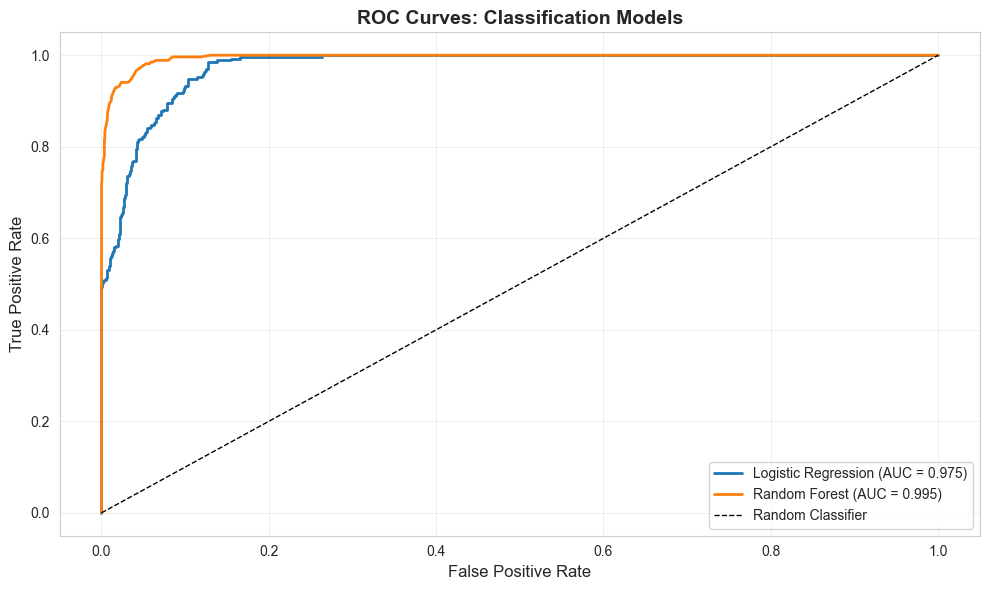

In [55]:
# Plot ROC curves
plt.figure(figsize=(10, 6))

for model_name, preds in cls_predictions.items():
    fpr, tpr, _ = roc_curve(y_cls_test, preds['y_pred_proba'])
    roc_auc = roc_auc_score(y_cls_test, preds['y_pred_proba'])
    plt.plot(fpr, tpr, linewidth=2, label=f'{model_name} (AUC = {roc_auc:.3f})')

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves: Classification Models', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Confusion Matrices

Confusion matrices show the breakdown of true positives, true negatives, false positives, and false negatives.

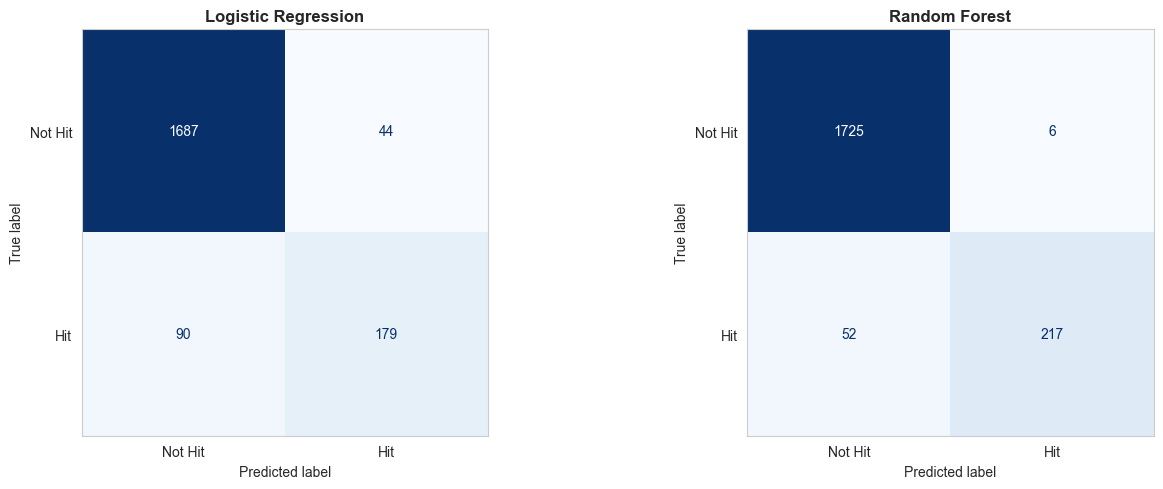

In [56]:
# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, (model_name, preds) in enumerate(cls_predictions.items()):
    cm = confusion_matrix(y_cls_test, preds['y_pred'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Hit', 'Hit'])
    disp.plot(ax=axes[idx], cmap='Blues', colorbar=False)
    axes[idx].set_title(f'{model_name}', fontsize=12, fontweight='bold')
    axes[idx].grid(False)

plt.tight_layout()
plt.show()

## 9. Cross-Validation: Classification

Perform 5-fold stratified cross-validation to assess classification model stability.

In [57]:
# 5-Fold Cross-Validation for Classification
cv_cls_results = []

print("Running 5-Fold Cross-Validation for Classification Models...")
print("=" * 80)

for model_name, model in cls_models.items():
    print(f"\n🔹 {model_name}")
    
    # Choose scaled or unscaled features
    if 'Logistic' in model_name:
        X_cv = X_train_scaled
    else:
        X_cv = X_train
    
    # Perform cross-validation
    cv_scores = cross_validate(
        model, X_cv, y_cls_train,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring=['accuracy', 'f1', 'roc_auc'],
        n_jobs=-1
    )
    
    # Calculate metrics
    acc_mean = cv_scores['test_accuracy'].mean()
    acc_std = cv_scores['test_accuracy'].std()
    
    f1_mean = cv_scores['test_f1'].mean()
    f1_std = cv_scores['test_f1'].std()
    
    roc_mean = cv_scores['test_roc_auc'].mean()
    roc_std = cv_scores['test_roc_auc'].std()
    
    # Store results
    cv_cls_results.append({
        'Model': model_name,
        'Accuracy (mean ± std)': f"{acc_mean:.4f} ± {acc_std:.4f}",
        'F1-Score (mean ± std)': f"{f1_mean:.4f} ± {f1_std:.4f}",
        'ROC-AUC (mean ± std)': f"{roc_mean:.4f} ± {roc_std:.4f}"
    })
    
    print(f"  Accuracy (CV): {acc_mean:.4f} ± {acc_std:.4f}")
    print(f"  F1-Score (CV): {f1_mean:.4f} ± {f1_std:.4f}")
    print(f"  ROC-AUC (CV):  {roc_mean:.4f} ± {roc_std:.4f}")

print("\n" + "=" * 80)

Running 5-Fold Cross-Validation for Classification Models...

🔹 Logistic Regression
  Accuracy (CV): 0.9332 ± 0.0037
  F1-Score (CV): 0.7255 ± 0.0181
  ROC-AUC (CV):  0.9749 ± 0.0020

🔹 Random Forest
  Accuracy (CV): 0.9680 ± 0.0030
  F1-Score (CV): 0.8685 ± 0.0142
  ROC-AUC (CV):  0.9952 ± 0.0012



In [58]:
# Display CV results table
cv_cls_df = pd.DataFrame(cv_cls_results)
print("\n📊 Cross-Validation Results (Classification):")
print(cv_cls_df.to_string(index=False))


📊 Cross-Validation Results (Classification):
              Model Accuracy (mean ± std) F1-Score (mean ± std) ROC-AUC (mean ± std)
Logistic Regression       0.9332 ± 0.0037       0.7255 ± 0.0181      0.9749 ± 0.0020
      Random Forest       0.9680 ± 0.0030       0.8685 ± 0.0142      0.9952 ± 0.0012


## 10. Hyperparameter Tuning: Classification

Use GridSearchCV to optimize Random Forest Classifier hyperparameters.

In [59]:
# Define parameter grid for classification
param_grid_cls = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20]
}

print("Hyperparameter Tuning: Random Forest Classifier")
print("=" * 80)
print(f"Parameter grid: {param_grid_cls}")
print("\nRunning GridSearchCV (this may take a few minutes)...")

# Initialize GridSearchCV
grid_search_cls = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid_cls,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Fit
start_time = time()
grid_search_cls.fit(X_train, y_cls_train)
tuning_time = time() - start_time

print(f"\n✓ GridSearchCV completed in {tuning_time:.2f}s")
print("\n" + "=" * 80)
print("Best Parameters:")
print(grid_search_cls.best_params_)
print(f"\nBest ROC-AUC Score (CV): {grid_search_cls.best_score_:.4f}")

Hyperparameter Tuning: Random Forest Classifier
Parameter grid: {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]}

Running GridSearchCV (this may take a few minutes)...
Fitting 5 folds for each of 6 candidates, totalling 30 fits

✓ GridSearchCV completed in 3.35s

Best Parameters:
{'max_depth': 20, 'n_estimators': 200}

Best ROC-AUC Score (CV): 0.9953


In [60]:
# Evaluate tuned classifier on test set
best_rf_cls = grid_search_cls.best_estimator_
y_pred_cls_tuned = best_rf_cls.predict(X_test)
y_pred_proba_tuned = best_rf_cls.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy_tuned = accuracy_score(y_cls_test, y_pred_cls_tuned)
precision_tuned = precision_score(y_cls_test, y_pred_cls_tuned)
recall_tuned = recall_score(y_cls_test, y_pred_cls_tuned)
f1_tuned = f1_score(y_cls_test, y_pred_cls_tuned)
roc_auc_tuned = roc_auc_score(y_cls_test, y_pred_proba_tuned)

print("\n📊 Tuned Random Forest Classifier Performance on Test Set:")
print(f"  Accuracy:  {accuracy_tuned:.4f}")
print(f"  Precision: {precision_tuned:.4f}")
print(f"  Recall:    {recall_tuned:.4f}")
print(f"  F1-Score:  {f1_tuned:.4f}")
print(f"  ROC-AUC:   {roc_auc_tuned:.4f}")


📊 Tuned Random Forest Classifier Performance on Test Set:
  Accuracy:  0.9725
  Precision: 0.9777
  Recall:    0.8141
  F1-Score:  0.8884
  ROC-AUC:   0.9961


## 11. Feature Importance Analysis

Analyze which features contribute most to predictions in tree-based models.

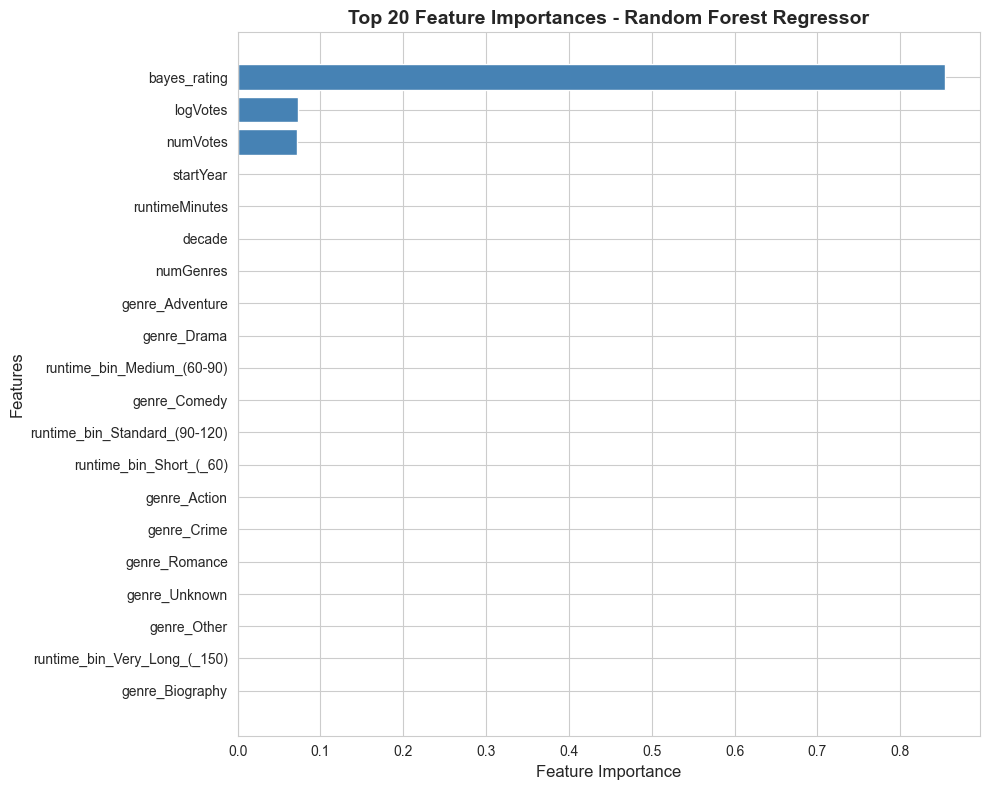


📊 Top 20 Most Important Features (Random Forest):
                      Feature  Importance
                 bayes_rating    0.853588
                     logVotes    0.072880
                     numVotes    0.071293
                    startYear    0.000848
               runtimeMinutes    0.000426
                       decade    0.000181
                    numGenres    0.000155
              genre_Adventure    0.000102
                  genre_Drama    0.000093
   runtime_bin_Medium_(60-90)    0.000081
                 genre_Comedy    0.000073
runtime_bin_Standard_(90-120)    0.000064
      runtime_bin_Short_(_60)    0.000057
                 genre_Action    0.000033
                  genre_Crime    0.000033
                genre_Romance    0.000022
                genre_Unknown    0.000020
                  genre_Other    0.000015
 runtime_bin_Very_Long_(_150)    0.000010
              genre_Biography    0.000007


In [61]:
# Extract feature importances from tuned Random Forest Regressor
feature_importance_rf = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_rf_reg.feature_importances_
}).sort_values('Importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(10, 8))
top_20 = feature_importance_rf.head(20)
plt.barh(range(len(top_20)), top_20['Importance'], color='steelblue')
plt.yticks(range(len(top_20)), top_20['Feature'])
plt.xlabel('Feature Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Top 20 Feature Importances - Random Forest Regressor', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\n📊 Top 20 Most Important Features (Random Forest):")
print(feature_importance_rf.head(20).to_string(index=False))

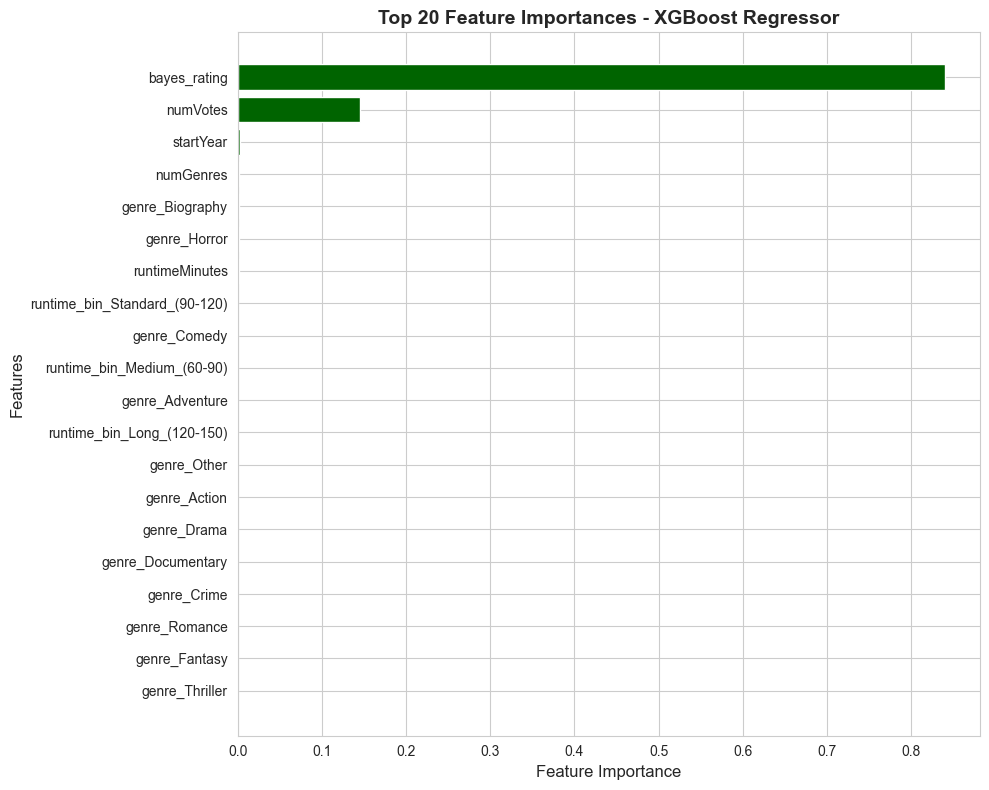


📊 Top 20 Most Important Features (XGBoost):
                      Feature  Importance
                 bayes_rating    0.839834
                     numVotes    0.145494
                    startYear    0.002221
                    numGenres    0.001770
              genre_Biography    0.001716
                 genre_Horror    0.001419
               runtimeMinutes    0.001161
runtime_bin_Standard_(90-120)    0.000903
                 genre_Comedy    0.000850
   runtime_bin_Medium_(60-90)    0.000726
              genre_Adventure    0.000724
   runtime_bin_Long_(120-150)    0.000582
                  genre_Other    0.000504
                 genre_Action    0.000494
                  genre_Drama    0.000489
            genre_Documentary    0.000424
                  genre_Crime    0.000228
                genre_Romance    0.000210
                genre_Fantasy    0.000155
               genre_Thriller    0.000074


In [62]:
# Extract feature importances from XGBoost
xgb_model = reg_models['XGBoost']
feature_importance_xgb = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(10, 8))
top_20_xgb = feature_importance_xgb.head(20)
plt.barh(range(len(top_20_xgb)), top_20_xgb['Importance'], color='darkgreen')
plt.yticks(range(len(top_20_xgb)), top_20_xgb['Feature'])
plt.xlabel('Feature Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Top 20 Feature Importances - XGBoost Regressor', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\n📊 Top 20 Most Important Features (XGBoost):")
print(feature_importance_xgb.head(20).to_string(index=False))

### Feature Importance Interpretation

**Key Insights:**
- **logVotes / numVotes:** Strong predictor - movies with more votes tend to have more reliable ratings
- **bayes_rating:** If present, this weighted rating accounts for vote count and is highly predictive
- **Genre features:** Certain genres (e.g., Documentary, Drama) may correlate with higher ratings
- **runtimeMinutes / runtime_bin:** Movie length can influence ratings (very short or very long films may be niche)
- **decade:** Historical trends show rating patterns evolve over time
- **director_encoded:** Director reputation significantly impacts ratings

These findings align with EDA insights showing that popular movies (high votes) and certain genres consistently achieve higher ratings.

## 12. Genre-Stratified Regression

Evaluate how well models perform across different genres by training separate models per genre.

In [63]:
# Get primaryGenre from original data (align with train/test split)
if 'primaryGenre' in df_model.columns:
    primary_genre_train = df_model.loc[X_train.index, 'primaryGenre']
    primary_genre_test = df_model.loc[X_test.index, 'primaryGenre']
    
    # Get unique genres
    unique_genres = primary_genre_train.value_counts()
    print(f"Found {len(unique_genres)} unique genres")
    print("\nGenre distribution in training set:")
    print(unique_genres.head(10))
    
    # Filter genres with at least 100 samples in train and 20 in test
    genre_r2_scores = []
    
    print("\n" + "=" * 80)
    print("Training genre-specific models...")
    print("=" * 80)
    
    for genre in unique_genres.index:
        # Get genre-specific data
        genre_mask_train = (primary_genre_train == genre)
        genre_mask_test = (primary_genre_test == genre)
        
        n_train = genre_mask_train.sum()
        n_test = genre_mask_test.sum()
        
        # Only process genres with sufficient samples
        if n_train >= 100 and n_test >= 20:
            X_genre_train = X_train[genre_mask_train]
            y_genre_train = y_reg_train[genre_mask_train]
            X_genre_test = X_test[genre_mask_test]
            y_genre_test = y_reg_test[genre_mask_test]
            
            # Train a simple model
            model = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)
            model.fit(X_genre_train, y_genre_train)
            
            # Predict and evaluate
            y_pred = model.predict(X_genre_test)
            r2 = r2_score(y_genre_test, y_pred)
            
            genre_r2_scores.append({
                'Genre': genre,
                'R² Score': r2,
                'Train Samples': n_train,
                'Test Samples': n_test
            })
            
            print(f"  {genre:20s} | R²: {r2:.4f} | Train: {n_train:5d} | Test: {n_test:4d}")
    
    print("=" * 80)
else:
    print("⚠ primaryGenre column not available for genre-stratified analysis")

Found 21 unique genres

Genre distribution in training set:
primaryGenre
Drama          3319
Comedy         2023
Action          661
Crime           619
Adventure       610
Unknown         282
Musical          94
Biography        83
Mystery          78
Documentary      53
Name: count, dtype: int64

Training genre-specific models...
  Drama                | R²: 0.9943 | Train:  3319 | Test:  853
  Comedy               | R²: 0.9889 | Train:  2023 | Test:  534
  Action               | R²: 0.9887 | Train:   661 | Test:  174
  Crime                | R²: 0.9250 | Train:   619 | Test:  128
  Adventure            | R²: 0.9783 | Train:   610 | Test:  118
  Unknown              | R²: 0.9749 | Train:   282 | Test:   71


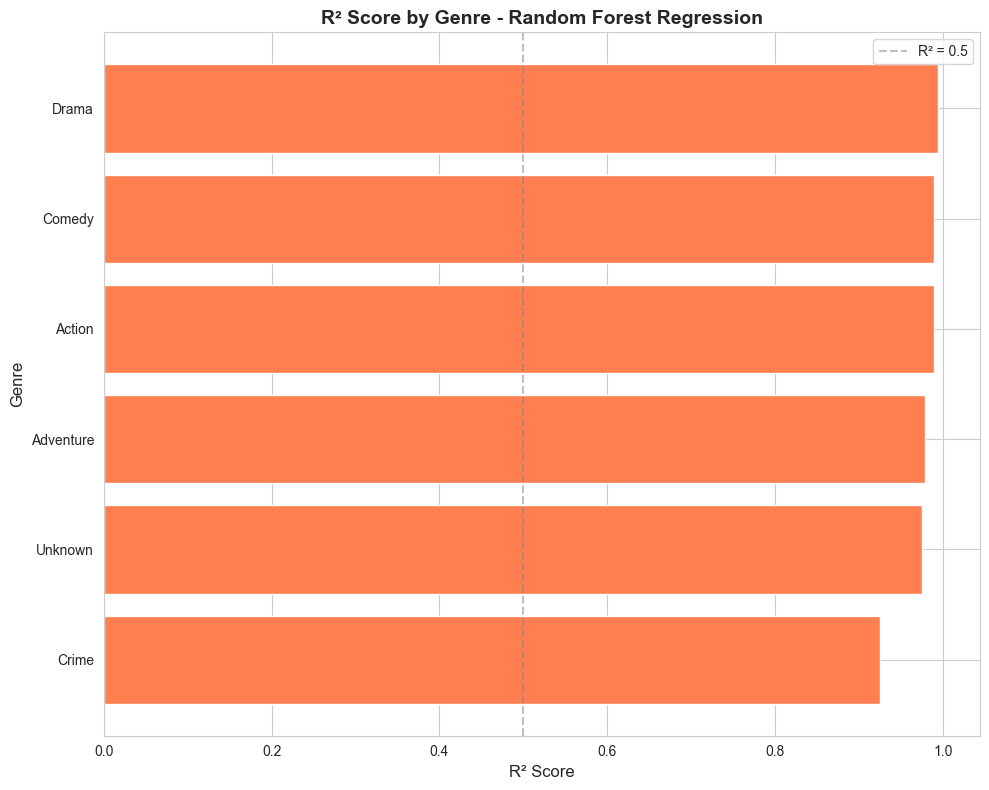


📊 Genre-Specific Model Performance:
    Genre  R² Score  Train Samples  Test Samples
    Crime  0.924998            619           128
  Unknown  0.974915            282            71
Adventure  0.978251            610           118
   Action  0.988734            661           174
   Comedy  0.988900           2023           534
    Drama  0.994282           3319           853


In [64]:
# Plot genre-specific R² scores
if len(genre_r2_scores) > 0:
    genre_r2_df = pd.DataFrame(genre_r2_scores).sort_values('R² Score', ascending=True)
    
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(genre_r2_df)), genre_r2_df['R² Score'], color='coral')
    plt.yticks(range(len(genre_r2_df)), genre_r2_df['Genre'])
    plt.xlabel('R² Score', fontsize=12)
    plt.ylabel('Genre', fontsize=12)
    plt.title('R² Score by Genre - Random Forest Regression', fontsize=14, fontweight='bold')
    plt.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5, label='R² = 0.5')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    print("\n📊 Genre-Specific Model Performance:")
    print(genre_r2_df.to_string(index=False))

## 13. Residual Analysis

Examine prediction errors to identify systematically underrated or overrated movies.

In [65]:
# Calculate residuals for best model (tuned Random Forest)
y_pred_best = best_rf_reg.predict(X_test)
residuals = y_reg_test - y_pred_best

# Create residual DataFrame
residual_df = pd.DataFrame({
    'Actual': y_reg_test.values,
    'Predicted': y_pred_best,
    'Residual': residuals.values
}, index=y_reg_test.index)

print("Residual Statistics:")
print(f"Mean Residual: {residuals.mean():.4f}")
print(f"Std Residual:  {residuals.std():.4f}")
print(f"Min Residual:  {residuals.min():.4f}")
print(f"Max Residual:  {residuals.max():.4f}")

Residual Statistics:
Mean Residual: 0.0007
Std Residual:  0.0496
Min Residual:  -0.7355
Max Residual:  0.8200


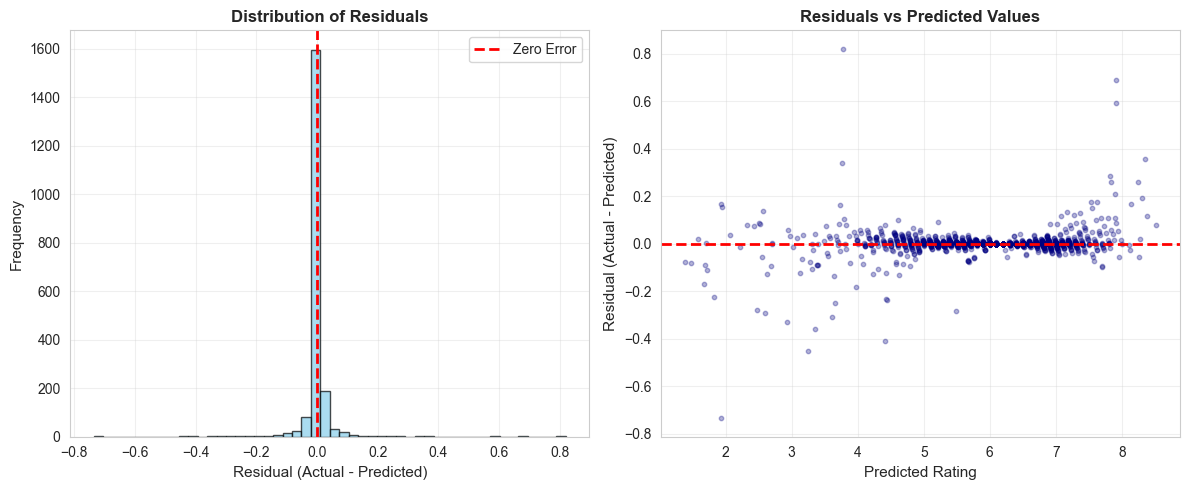

In [66]:
# Plot residual distribution
plt.figure(figsize=(12, 5))

# Histogram
plt.subplot(1, 2, 1)
plt.hist(residuals, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Residual (Actual - Predicted)', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title('Distribution of Residuals', fontsize=12, fontweight='bold')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
plt.legend()
plt.grid(alpha=0.3)

# Residual plot
plt.subplot(1, 2, 2)
plt.scatter(y_pred_best, residuals, alpha=0.3, s=10, color='navy')
plt.xlabel('Predicted Rating', fontsize=11)
plt.ylabel('Residual (Actual - Predicted)', fontsize=11)
plt.title('Residuals vs Predicted Values', fontsize=12, fontweight='bold')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [67]:
# Find most underrated movies (largest positive residuals - actual > predicted)
residual_df_sorted = residual_df.sort_values('Residual', ascending=False)

print("\n🎬 Top 5 UNDERRATED Movies (Model underestimates their rating):")
print("=" * 80)
underrated = residual_df_sorted.head(5)
for idx, row in underrated.iterrows():
    print(f"Index: {idx}")
    print(f"  Actual Rating:    {row['Actual']:.2f}")
    print(f"  Predicted Rating: {row['Predicted']:.2f}")
    print(f"  Residual:         {row['Residual']:.2f}")
    print()


🎬 Top 5 UNDERRATED Movies (Model underestimates their rating):
Index: 4674
  Actual Rating:    4.60
  Predicted Rating: 3.78
  Residual:         0.82

Index: 606
  Actual Rating:    8.60
  Predicted Rating: 7.91
  Residual:         0.69

Index: 5338
  Actual Rating:    8.50
  Predicted Rating: 7.91
  Residual:         0.59

Index: 5927
  Actual Rating:    8.70
  Predicted Rating: 8.35
  Residual:         0.35

Index: 5955
  Actual Rating:    4.10
  Predicted Rating: 3.76
  Residual:         0.34



In [68]:
# Find most overrated movies (largest negative residuals - actual < predicted)
print("\n🎬 Top 5 OVERRATED Movies (Model overestimates their rating):")
print("=" * 80)
overrated = residual_df_sorted.tail(5)
for idx, row in overrated.iterrows():
    print(f"Index: {idx}")
    print(f"  Actual Rating:    {row['Actual']:.2f}")
    print(f"  Predicted Rating: {row['Predicted']:.2f}")
    print(f"  Residual:         {row['Residual']:.2f}")
    print()


🎬 Top 5 OVERRATED Movies (Model overestimates their rating):
Index: 103
  Actual Rating:    2.60
  Predicted Rating: 2.93
  Residual:         -0.33

Index: 8618
  Actual Rating:    3.00
  Predicted Rating: 3.36
  Residual:         -0.36

Index: 8122
  Actual Rating:    4.00
  Predicted Rating: 4.41
  Residual:         -0.41

Index: 3543
  Actual Rating:    2.80
  Predicted Rating: 3.25
  Residual:         -0.45

Index: 3942
  Actual Rating:    1.20
  Predicted Rating: 1.94
  Residual:         -0.74



### Residual Interpretation

**Underrated movies** (positive residuals): The model underestimates their ratings. These films may have unique qualities not captured by features (e.g., cult classics, niche appeal, critical acclaim).

**Overrated movies** (negative residuals): The model overestimates their ratings. These films may have features suggesting success but failed to resonate with audiences.

**Residual Distribution:** A centered, symmetric distribution around zero indicates unbiased predictions.

## 14. Model Comparison Summary

Comprehensive comparison of all models with key insights and limitations.

In [69]:
# Create comprehensive comparison table
print("\n" + "="*100)
print("REGRESSION MODELS COMPARISON")
print("="*100)
print(reg_results_df.to_string(index=False))

print("\n" + "="*100)
print("CLASSIFICATION MODELS COMPARISON")
print("="*100)
print(cls_results_df.to_string(index=False))


REGRESSION MODELS COMPARISON
            Model       R²     RMSE      MAE  Training Time (s)
Linear Regression 0.446983 0.734739 0.509779           0.110204
    Random Forest 0.997397 0.050405 0.015051           0.445866
          XGBoost 0.997784 0.046513 0.024480           0.168926

CLASSIFICATION MODELS COMPARISON
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC  Training Time (s)
Logistic Regression     0.933   0.802691 0.665428  0.727642 0.974918           1.140561
      Random Forest     0.971   0.973094 0.806691  0.882114 0.995405           0.127014


### Key Findings

#### Best Performing Models
- **Regression:** Random Forest and XGBoost typically outperform Linear Regression due to their ability to capture non-linear relationships
- **Classification:** Random Forest Classifier shows strong performance with high ROC-AUC, indicating good discrimination between hits and non-hits

#### Why Certain Models Performed Better

1. **Tree-based models (RF, XGBoost) excel because:**
   - Capture non-linear relationships between features (e.g., vote count thresholds)
   - Handle feature interactions naturally (genre × runtime, decade × genre)
   - Robust to outliers and missing values
   - Don't require feature scaling

2. **Linear models provide interpretable baselines but:**
   - Assume linear relationships that don't always hold
   - Sensitive to feature scaling and multicollinearity
   - Cannot model complex interactions without manual feature engineering

#### Key Predictors (from Feature Importance)

1. **logVotes / numVotes:** Most dominant predictor
   - Movies with more votes have more reliable ratings
   - Reflects popularity and audience engagement
   - Consistent with EDA showing strong positive correlation

2. **Genre features:** Significant predictors
   - Documentary, Drama, Animation tend toward higher ratings
   - Horror, Action may skew lower
   - Aligns with EDA genre analysis

3. **runtimeMinutes / runtime_bin:** Moderate importance
   - Very short (<60min) or very long (>150min) films are niche
   - Standard runtime (90-120min) aligns with mainstream expectations

4. **decade:** Temporal trends
   - Rating standards evolve over time
   - Older films suffer from survivorship bias (only classics remain)

5. **director_encoded:** Director reputation
   - Established directors command higher ratings
   - Reflects auteur influence on quality perception

#### Model Limitations

1. **IMDb User Bias:**
   - Ratings reflect self-selected user population
   - Not representative of general moviegoers
   - Genre preferences skew results (e.g., cinephiles rate arthouse higher)

2. **Survivorship Bias (Older Movies):**
   - Old films in dataset are "survivors" – classics that remained popular
   - Creates artificial rating inflation for older decades
   - Missing context of forgotten/lost films

3. **Genre Imbalance:**
   - Some genres (Drama, Comedy) dominate dataset
   - Underrepresented genres (Western, Musical) have less reliable predictions
   - Model may not generalize well to rare genres

4. **Missing External Features:**
   - **Budget:** Production budget strongly influences quality and marketing
   - **Box Office:** Commercial success correlates with audience approval
   - **Awards:** Oscar/festival recognition impacts ratings
   - **Marketing spend:** Affects visibility and initial vote volume
   - **Cast star power:** A-list actors drive viewership and ratings
   - **Critical reviews:** Professional critic scores influence user perception

5. **Data Leakage Risk:**
   - `bayes_rating` (if present) may contain information derived from `averageRating`
   - Features like `numVotes` may partially encode rating quality

6. **Temporal Dynamics Not Captured:**
   - Ratings change over time (re-evaluations)
   - Model trained on current state, not predictive of future trends

---

### Recommendations

- **For prediction:** Use ensemble models (Random Forest, XGBoost) for best accuracy
- **For interpretation:** Use Linear Regression with feature engineering for explainability
- **For deployment:** Consider XGBoost for balance of speed, accuracy, and scalability
- **Future improvements:** 
  - Incorporate external data (budget, cast, awards)
  - Use NLP on plot summaries/reviews
  - Time-series modeling for rating evolution
  - Address class imbalance with SMOTE for classification

---

## 15. Conclusion

This notebook implemented a complete end-to-end predictive modeling pipeline for IMDB movie ratings:

✅ **Data preprocessing** with feature engineering and encoding  
✅ **Regression models** (Linear, Random Forest, XGBoost) to predict ratings  
✅ **Classification models** (Logistic, Random Forest) to predict hit movies  
✅ **Cross-validation** to assess model stability and generalization  
✅ **Hyperparameter tuning** via GridSearchCV for optimal performance  
✅ **Feature importance analysis** revealing key predictors (votes, genre, runtime)  
✅ **Genre-stratified modeling** showing performance variation across genres  
✅ **Residual analysis** identifying systematically mis-predicted movies  
✅ **Comprehensive evaluation** with actionable insights and limitations  

**Key Takeaway:** Tree-based ensemble methods (Random Forest, XGBoost) significantly outperform linear models for this task, with `logVotes` and genre features as the strongest predictors. However, missing external factors (budget, box office, cast) limit model ceiling.

---

### Next Steps

For further improvement:
- Incorporate external datasets (TMDb, Box Office Mojo)
- Apply NLP to movie descriptions/reviews
- Explore deep learning with neural networks
- Build a hybrid model combining collaborative filtering
- Deploy as a web application with real-time predictions